In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# Tentukan path untuk data
train_data_dir = "/Users/anggun/Downloads/SKRIPSI ANGGUN/ANGGUN/2. Data Train & Validation"
test_data_dir = "/Users/anggun/Downloads/SKRIPSI ANGGUN/ANGGUN/2. Data Test"

In [3]:
# Fungsi untuk memuat data dari folder dan mengembalikan generator
batch_size = 32
target_size = (299, 299)  # Ganti target_size ke 299x299
def load_data(data_dir, batch_size, target_size):
    data_generator = ImageDataGenerator(rescale=1./255)
    data_flow = data_generator.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    return data_flow

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Fungsi augmentasi khusus
def custom_augmentation(x):
    if np.random.random() < 0.5:
        x = np.flip(x, axis=1)  # Flip horizontal
    if np.random.random() < 0.5:
        x = np.flip(x, axis=0)  # Flip vertikal
    if np.random.random() < 0.5:
        x = tf.keras.preprocessing.image.random_rotation(x, 90, row_axis=0, col_axis=1, channel_axis=2)  # Rotate right (90 derajat)
    if np.random.random() < 0.5:
        x = tf.keras.preprocessing.image.random_rotation(x, -90, row_axis=0, col_axis=1, channel_axis=2)  # Rotate left (-90 derajat)
    return x

# Data generator dengan augmentasi
data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_augmentation
)

# Aliran data
data_flow = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),  # Ubah ke 299x299
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 540 images belonging to 3 classes.


In [5]:
# Memuat data train ke dalam array
X_data = []
y_data = []

In [6]:
# Loop through batches using the iterator protocol (no need for next())
for i, (X_batch, y_batch) in enumerate(data_flow):
    X_data.append(X_batch)
    y_data.append(y_batch)

    if i >= len(data_flow) - 1:
        break

# Memuat data test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(299, 299),  # Ubah ke 299x299
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 60 images belonging to 3 classes.


In [7]:
X_data = np.concatenate(X_data)
y_data = np.concatenate(y_data)

In [8]:
#  Model InceptionV3
def create_inception_model():
    inception_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))  # Ganti input_shape
    inception_model.trainable = False  # Menggunakan bobot yang sudah dilatih

    model_inception = tf.keras.Sequential([
        inception_model,
        tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    # Kompilasi model
    model_inception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    return model_inception

In [9]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

In [10]:
# ====== 2. IMPORT LIBRARY LAIN ======
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold


# Misalnya, Anda telah mengumpulkan histori dari setiap fold
fold_accuracies = []
fold_losses = []
fold_val_accuracies = []
fold_val_losses = []
fold_accuracy = []
y_true_val = []
y_pred_val = []
y_true_test = []
y_pred_test = []
confusion_matrices=[]
fold_summaries = []


for fold, (train_index, val_index) in enumerate (kfold.split(X_data)):
    X_train, X_val = X_data[train_index], X_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]
    
    modelinception = create_inception_model()
    history = modelinception.fit(
        X_train,
        y_train,
        batch_size=10,
        epochs=10,
        validation_data=(X_val, y_val)
    )
    #evaluasi
    _, accuracy = modelinception.evaluate(X_val, y_val)
    fold_accuracy.append(accuracy)
    
    # Simpan histori dari setiap fold
    fold_accuracies.append(history.history['accuracy'])
    fold_losses.append(history.history['loss'])
    fold_val_accuracies.append(history.history['val_accuracy'])
    fold_val_losses.append(history.history['val_loss'])
    
    # Prediksi untuk data validasi
    y_pred_fold = np.argmax(modelinception.predict(X_val), axis=1)
    y_true_fold = np.argmax(y_val, axis=1)

    y_pred_val.extend(y_pred_fold)
    y_true_val.extend(y_true_fold)
# Menghitung confusion matrix
    cm = confusion_matrix(y_true_fold, y_pred_fold)
    confusion_matrices.append(cm)
    
    # Menghitung summary dari confusion matrix
    accuracy = accuracy_score(y_true_fold, y_pred_fold)
    precision = precision_score(y_true_fold, y_pred_fold, average='weighted')
    recall = recall_score(y_true_fold, y_pred_fold, average='weighted')
    f1 = f1_score(y_true_fold, y_pred_fold, average='weighted')
    fold_summaries.append((accuracy, precision, recall, f1))

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 417s 9s/step - accuracy: 0.4199 - loss: 3.2268 - val_accuracy: 0.7037 - val_loss: 0.6024
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 347s 9s/step - accuracy: 0.7648 - loss: 0.5070 - val_accuracy: 0.8815 - val_loss: 0.4192
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 342s 8s/step - accuracy: 0.8383 - loss: 0.3718 - val_accuracy: 0.8889 - val_loss: 0.3127
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 349s 9s/step - accuracy: 0.9265 - loss: 0.3082 - val_accuracy: 0.9259 - val_loss: 0.1675
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 344s 8s/step - accuracy: 0.9455 - loss: 0.1622 - val_accuracy: 0.9333 - val_loss: 0.1502
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 343s 8s/step - accuracy: 0.9485 - loss: 0.1335 - val_accuracy: 0.9556 - val_loss: 0.1154
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 338s 8s/step - accuracy: 0.9542 - loss: 0.1005 - val_accuracy: 0.9630 - val_loss: 0.1136
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 333s 8s/step - accuracy: 0.9647 - loss: 0.0891 - val_accuracy: 0.9556 - v

In [11]:
# Contoh output
print("Akurasi setiap fold:", fold_accuracy)
print("Prediksi validasi:", y_pred_val)
print("Label asli validasi:", y_true_val)
print("Prediksi test:", y_pred_test)
print("Label asli test:", y_true_test)

Akurasi setiap fold: [0.9407407641410828, 0.9259259104728699, 0.8888888955116272, 0.9407407641410828]
Prediksi validasi: [np.int64(1), np.int64(0), np.int64(2), np.int64(2), np.int64(1), np.int64(2), np.int64(2), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(2), np.int64(0), np.int64(2), np.int64(2), np.int64(0), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(2), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(0), np.int64(2), np.int64(2), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(2), np.int64(0), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(2), np.int64(2), np.int64(1), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(2), np.int64(1), np.int64(2), np.int64(0), np.int64(2), np.int64(2), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(2), np.int64(1), np.int64(2), np.int6

In [12]:
modelinception.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_379 (Conv2D)             │ (None, 8, 8, 32)       │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,770,507 (90.68 MB)

 Trainable params: 655,907 (2.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 1,311,816 (5.00 MB)

In [13]:
# Plotting grafik untuk semua fold
#epochs = range(1, 11) jika  epoch sebanyak 11
epochs = list(range(1, 11))  # 1 sampai 20

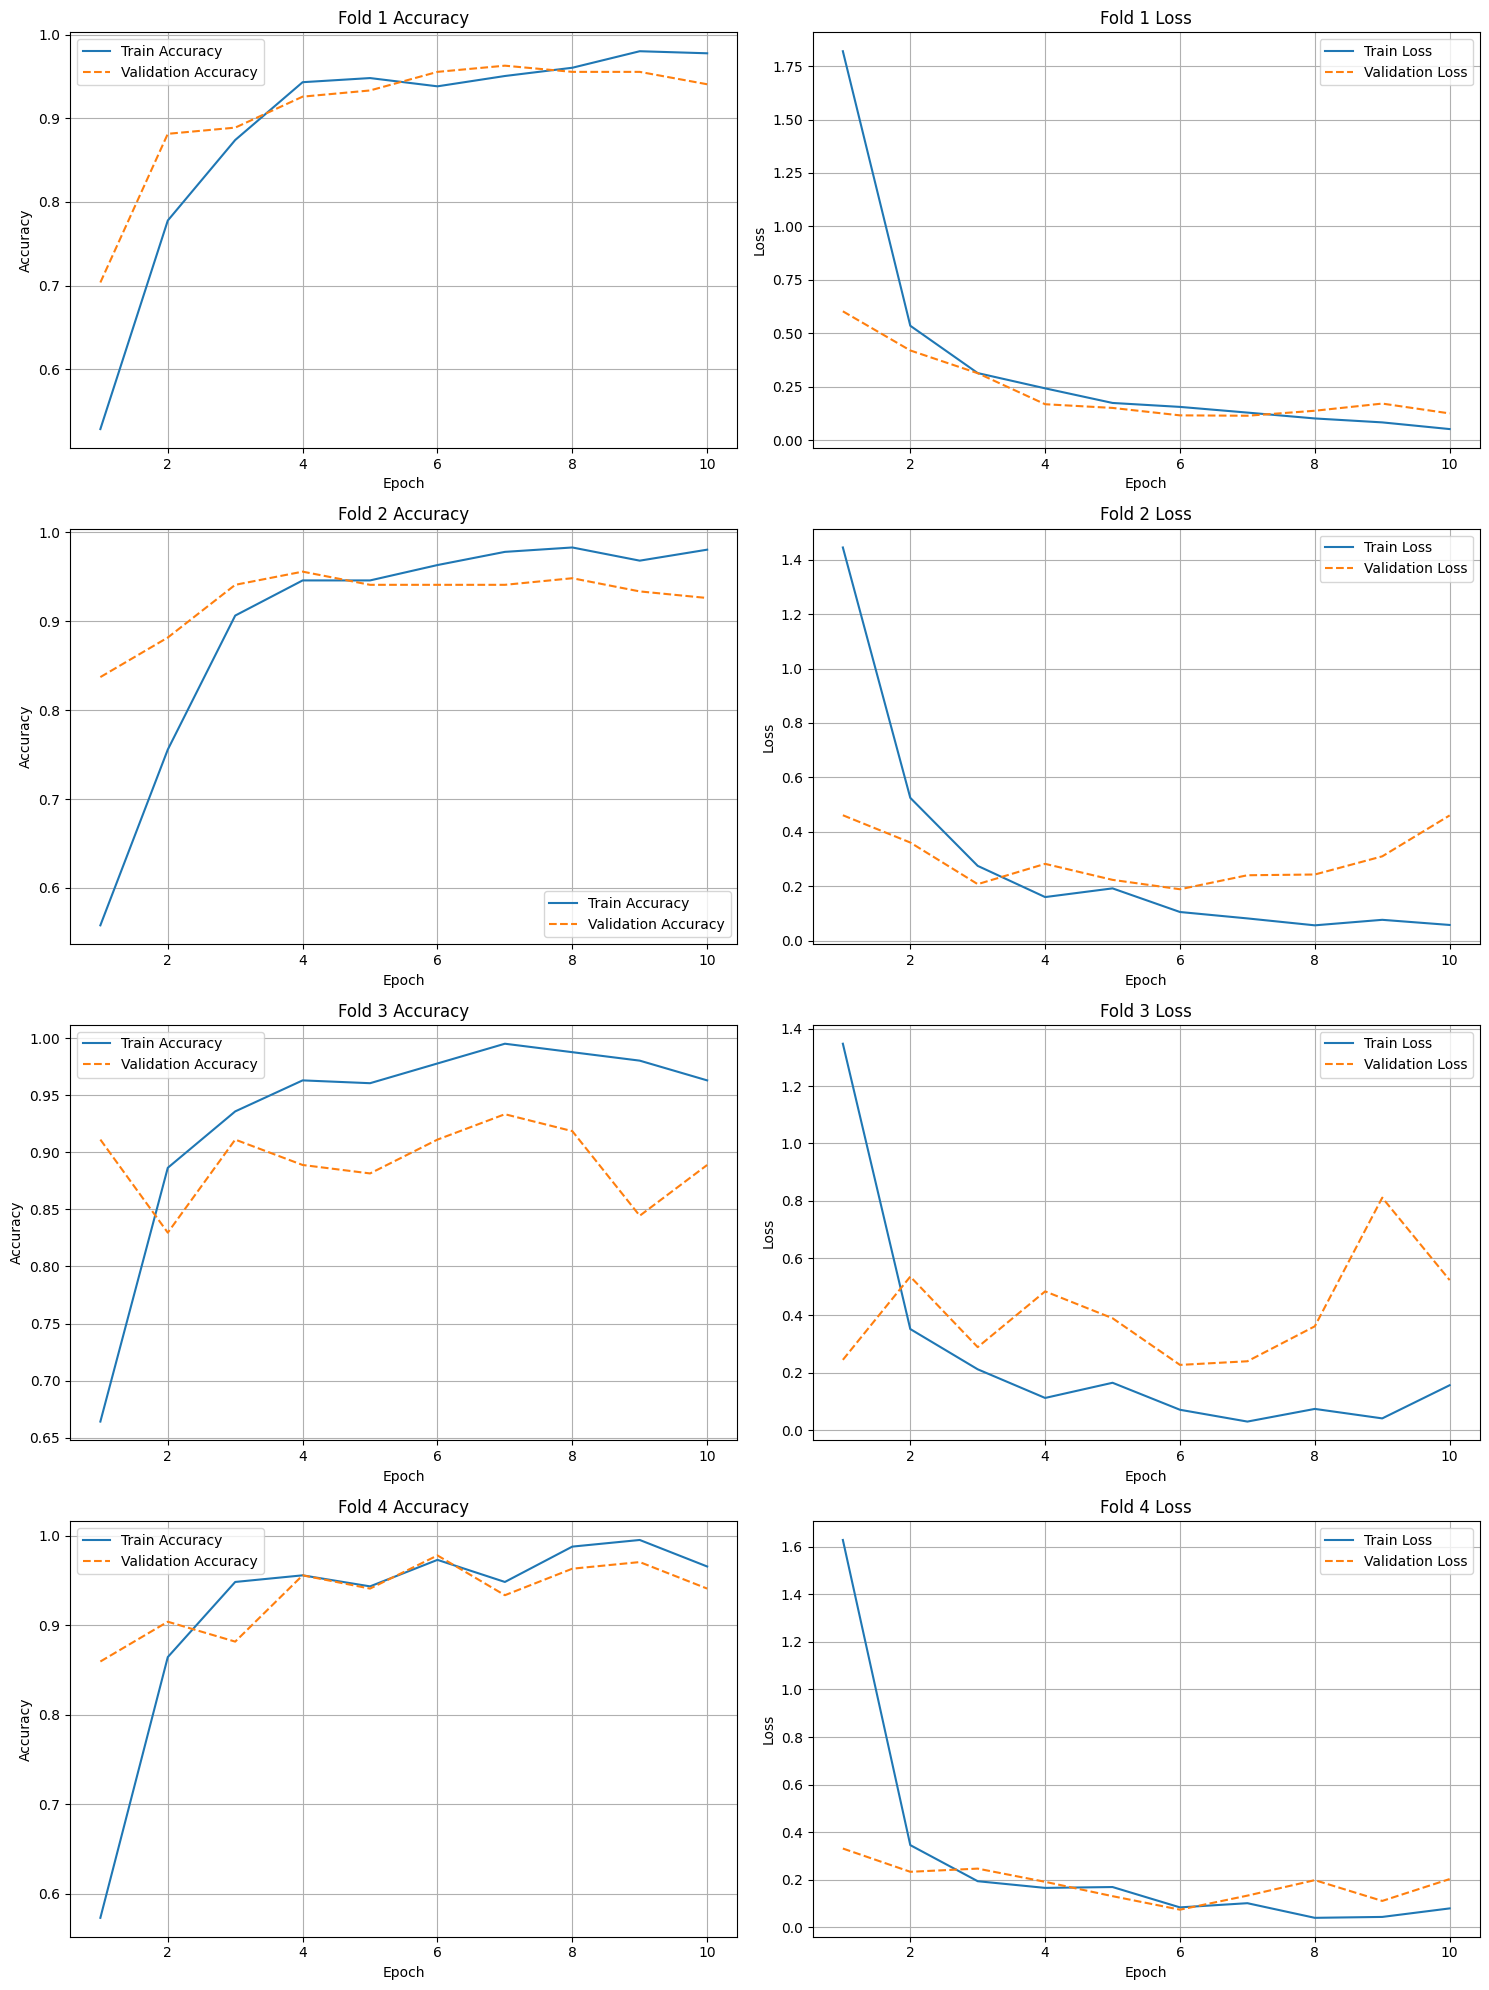

In [14]:
import matplotlib.pyplot as plt

# Pastikan fold_accuracies, fold_val_accuracies, fold_losses, fold_val_losses, dan epochs terdefinisi dengan benar

# Tentukan jumlah fold
num_folds = len(fold_accuracies)

# Setup subplot grid dengan 4 baris dan 2 kolom (total 8 grafik)
plt.figure(figsize=(15, 20))

for i in range(num_folds):
    # Subplot untuk Accuracy
    plt.subplot(num_folds, 2, 2 * i + 1)
    plt.plot(epochs, fold_accuracies[i], label='Train Accuracy')
    plt.plot(epochs, fold_val_accuracies[i], label='Validation Accuracy', linestyle='--')
    plt.title(f'Fold {i + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Subplot untuk Loss
    plt.subplot(num_folds, 2, 2 * i + 2)
    plt.plot(epochs, fold_losses[i], label='Train Loss')
    plt.plot(epochs, fold_val_losses[i], label='Validation Loss', linestyle='--')
    plt.title(f'Fold {i + 1} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

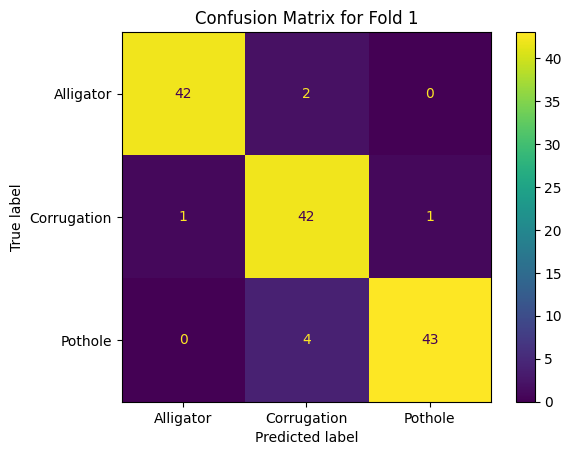

Summary for Fold 1:
Accuracy: 0.9407407407407408
Precision: 0.9437671286508497
Recall: 0.9407407407407408
F1 Score: 0.9412907709759283




<Figure size 640x480 with 0 Axes>

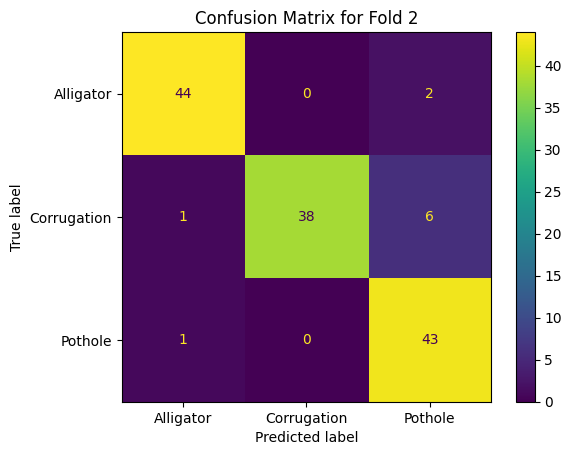

Summary for Fold 2:
Accuracy: 0.9259259259259259
Precision: 0.9340595497458243
Recall: 0.9259259259259259
F1 Score: 0.9261955424035324




<Figure size 640x480 with 0 Axes>

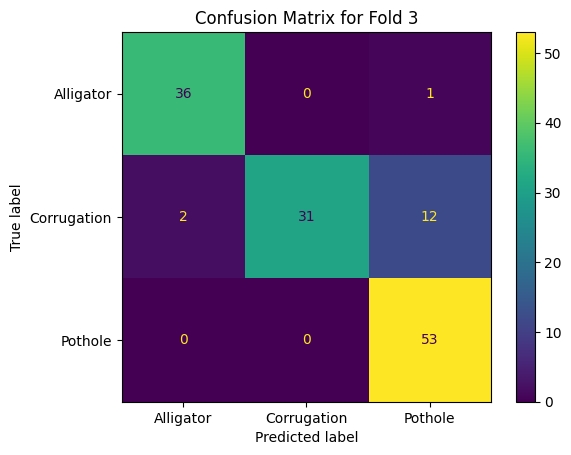

Summary for Fold 3:
Accuracy: 0.8888888888888888
Precision: 0.9082462047374328
Recall: 0.8888888888888888
F1 Score: 0.8847452618474289




<Figure size 640x480 with 0 Axes>

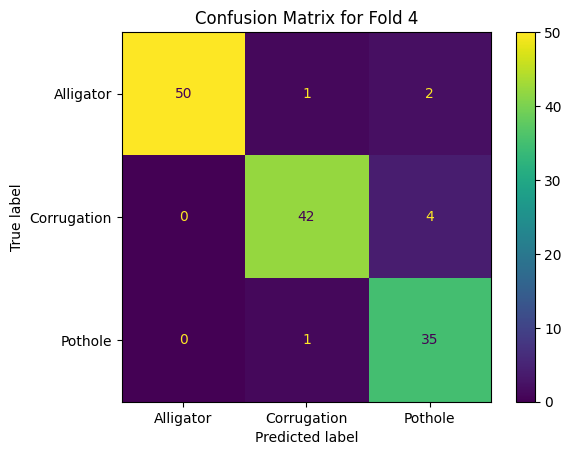

Summary for Fold 4:
Accuracy: 0.9407407407407408
Precision: 0.9454873942678821
Recall: 0.9407407407407408
F1 Score: 0.9416067906682792




In [15]:
# Menampilkan confusion matrices dan summaries 
for i, cm in enumerate(confusion_matrices):
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_flow.class_indices.keys())
    disp.plot()
    plt.title(f'Confusion Matrix for Fold {i + 1}')
    plt.show()
    
    accuracy, precision, recall, f1 = fold_summaries[i]
    print(f"Summary for Fold {i + 1}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\n")

In [16]:
# Menampilkan rata-rata akurasi dari cross-validation
print("Cross-validation accuracy:", np.mean(fold_accuracy))

Cross-validation accuracy: 0.9240740835666656


In [17]:
# Menghitung confusion matrix
cm = confusion_matrix(y_true_fold, y_pred_fold)
confusion_matrices.append(cm)

In [18]:
# Menampilkan confusion matrices
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i + 1}:\n{cm}\n")

Confusion Matrix for Fold 1:
[[42  2  0]
 [ 1 42  1]
 [ 0  4 43]]

Confusion Matrix for Fold 2:
[[44  0  2]
 [ 1 38  6]
 [ 1  0 43]]

Confusion Matrix for Fold 3:
[[36  0  1]
 [ 2 31 12]
 [ 0  0 53]]

Confusion Matrix for Fold 4:
[[50  1  2]
 [ 0 42  4]
 [ 0  1 35]]

Confusion Matrix for Fold 5:
[[50  1  2]
 [ 0 42  4]
 [ 0  1 35]]



/opt/anaconda3/envs/Anggun/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.9562 - loss: 0.2700
Test Accuracy: 0.949999988079071
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step


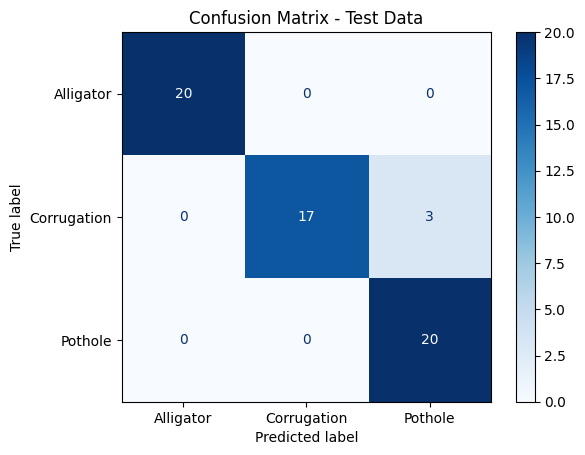

              precision    recall  f1-score   support

   Alligator       1.00      1.00      1.00        20
 Corrugation       1.00      0.85      0.92        20
     Pothole       0.87      1.00      0.93        20

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



In [19]:
test_scores = modelinception.evaluate(test_generator)
print("Test Accuracy:", test_scores[1])
# Prediksi dari model
y_pred_test = modelinception.predict(test_generator)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Label sebenarnya
y_true_test = test_generator.classes

# Hitung confusion matrix
test_cm = confusion_matrix(y_true_test, y_pred_test_classes)

# Nama kelas
classes = list(test_generator.class_indices.keys())

# Tampilkan confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=classes)
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.show()

# Tampilkan laporan klasifikasi
print(classification_report(y_true_test, y_pred_test_classes, target_names=classes))

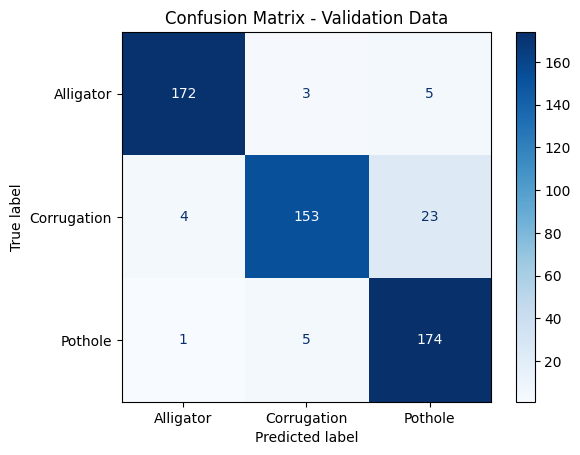

In [29]:
# Menghitung dan menampilkan confusion matrix untuk data validasi
val_cm = confusion_matrix(y_true_val, y_pred_val)
classes = list(test_generator.class_indices.keys())
disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=classes)
disp_val.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

In [30]:
# Menampilkan precision, recall, f1-score, dan accuracy dari hasil confusion matrix untuk data train
print(classification_report(y_true_val, y_pred_val, target_names=classes))

              precision    recall  f1-score   support

   Alligator       0.97      0.96      0.96       180
 Corrugation       0.95      0.85      0.90       180
     Pothole       0.86      0.97      0.91       180

    accuracy                           0.92       540
   macro avg       0.93      0.92      0.92       540
weighted avg       0.93      0.92      0.92       540



In [31]:
test_scores = modelinception.evaluate(test_generator)
print("Test Accuracy:", test_scores[1])

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9562 - loss: 0.2700
Test Accuracy: 0.949999988079071


In [34]:
modelinception.save('inceptionv3_new10.h5')